In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [12]:
train_x = np.linspace(0, 1, 100)
train_y = np.sin(train_x * (2 * np.pi)) + np.random.randn(train_x.size) * np.sqrt(0.04)

tensor_train_x = torch.tensor(train_x)
tensor_train_y = torch.tensor(train_y)

In [13]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [14]:

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(tensor_train_x, tensor_train_y, likelihood)

In [16]:
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(tensor_train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, tensor_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.942   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.911   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.877   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.840   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.797   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.750   lengthscale: 0.476   noise: 0.474
Iter 7/50 - Loss: 0.699   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.646   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.596   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.551   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.509   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.472   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.436   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.402   lengthscale: 0.255   noise: 0.236
Iter 15/50 - Loss: 0.369   lengthscale: 0.242   noise: 0.215
Iter 16/50 - Loss: 0.336   lengthscale: 0.232   noise: 0.196
Iter 17/50 - Loss: 0.303   length

In [27]:
test_x = np.linspace(0, 1, 51)
tensor_test_x = torch.tensor(test_x)

model.eval()
likelihood.eval()


f_preds = model(tensor_test_x)
y_preds = likelihood(model(tensor_test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

/oak/stanford/orgs/kipac/users/delon/miniconda3/envs/massfunction/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


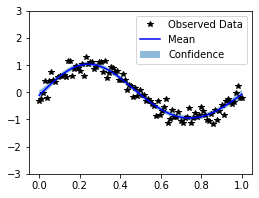

In [30]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
with torch.no_grad():
    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x, train_y, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x, f_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


In [32]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.3159])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(-0.1168)),
             ('covar_module.raw_outputscale', tensor(0.8166)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.1638]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [34]:
torch.tensor(-1).unsqueeze(-1)

tensor([-1])

In [78]:
np.einsum('x,y-> xy', [1,2,3], -np.array([4,5]))

array([[ -4,  -5],
       [ -8, -10],
       [-12, -15]])

In [80]:
np.subtract.outer([1,2,3], [4,5])


array([[-3, -4],
       [-2, -3],
       [-1, -2]])

In [131]:
np.mean([1,2,3])

2.0

In [139]:
class numpy_ConstantMean():
    def __init__(self, raw_constant):
        self.constant = raw_constant
    def __call__(self, input):
        return self.constant * np.ones_like(input)
        
class numpy_ScaleKernel():
    def __init__(self, base_kernel, scale):
        self.base_kernel = base_kernel
        self.scale = scale
    
    def __call__(self, x1, x2):
        return self.base_kernel(x1, x2)*self.scale

class numpy_RBFKernel():
    def __init__(self, lengthscale):
        self.lengthscale = lengthscale
        
    def __call__(self, x1, x2):
        x1 = x1 - np.mean(x1)
        x2 = x2 - np.mean(x2)
        x1_ = x1 / self.lengthscale
        x2_ = x2 / self.lengthscale
        X = np.subtract.outer(x1_,x2_)
        return np.exp(-np.square(X)/(2))

In [140]:
model.mean_module(tensor_train_x)

tensor([-0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168, -0.1168,
        -0.1168, -0.1168, -0.1168, -0.11

In [141]:
tmp_mean_module = numpy_ConstantMean(model.state_dict()['mean_module.raw_constant'].numpy())
print(tmp_mean_module(train_x))

np.allclose(model.mean_module(tensor_train_x).detach().numpy(), 
            tmp_mean_module(train_x) )

[-0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0.11676148
 -0.11676148 -0.11676148 -0.11676148 -0.11676148 -0

True

In [142]:
model.covar_module(tensor_train_x, tensor_test_x).to_dense()

tensor([[1.1826, 1.1794, 1.1699,  ..., 0.0023, 0.0018, 0.0014],
        [1.1818, 1.1818, 1.1755,  ..., 0.0026, 0.0020, 0.0016],
        [1.1793, 1.1826, 1.1795,  ..., 0.0030, 0.0023, 0.0018],
        ...,
        [0.0018, 0.0023, 0.0030,  ..., 1.1795, 1.1826, 1.1793],
        [0.0016, 0.0020, 0.0026,  ..., 1.1755, 1.1818, 1.1818],
        [0.0014, 0.0018, 0.0023,  ..., 1.1699, 1.1794, 1.1826]],
       dtype=torch.float64, grad_fn=<MulBackward0>)

In [143]:
tmp_base_kernel = numpy_RBFKernel(model.state_dict()['covar_module.base_kernel.raw_lengthscale'].numpy())
tmp_covar_module = numpy_ScaleKernel(tmp_base_kernel, 
                                     model.state_dict()['covar_module.raw_outputscale'].numpy())


print(tmp_covar_module(train_x, test_x))



np.allclose(model.covar_module(tensor_train_x, tensor_test_x).to_dense().detach(),
            tmp_covar_module(train_x, test_x) )

[[[[0.81661707 0.81649651 0.81613492 ... 0.5811342  0.57287041
    0.56455739]]

  [[0.81658632 0.81658753 0.81634765 ... 0.58528733 0.57705054
    0.56876169]]

  [[0.81649406 0.81661706 0.81649893 ... 0.58942575 0.5812174
    0.57295414]]

  ...

  [[0.57295414 0.5812174  0.58942575 ... 0.81649893 0.81661706
    0.81649406]]

  [[0.56876169 0.57705054 0.58528733 ... 0.81634765 0.81658753
    0.81658632]]

  [[0.56455739 0.57287041 0.5811342  ... 0.81613492 0.81649651
    0.81661707]]]]


False

In [144]:
model.covar_module.base_kernel(tensor_train_x, tensor_test_x).to_dense()

tensor([[1.0000, 0.9973, 0.9892,  ..., 0.0020, 0.0015, 0.0011],
        [0.9993, 0.9993, 0.9940,  ..., 0.0022, 0.0017, 0.0013],
        [0.9972, 1.0000, 0.9974,  ..., 0.0025, 0.0020, 0.0015],
        ...,
        [0.0015, 0.0020, 0.0025,  ..., 0.9974, 1.0000, 0.9972],
        [0.0013, 0.0017, 0.0022,  ..., 0.9940, 0.9993, 0.9993],
        [0.0011, 0.0015, 0.0020,  ..., 0.9892, 0.9973, 1.0000]],
       dtype=torch.float64, grad_fn=<RBFCovarianceBackward>)

In [145]:
tmp_base_kernel(train_x, test_x)

array([[[[1.        , 0.99985236, 0.99940957, ..., 0.71163611,
          0.70151657, 0.69133675]],

        [[0.99996234, 0.99996383, 0.99967007, ..., 0.71672189,
          0.70663541, 0.69648518]],

        [[0.99984936, 0.99999998, 0.99985533, ..., 0.72178965,
          0.711738  , 0.7016191 ]],

        ...,

        [[0.7016191 , 0.711738  , 0.72178965, ..., 0.99985533,
          0.99999998, 0.99984936]],

        [[0.69648518, 0.70663541, 0.71672189, ..., 0.99967007,
          0.99996383, 0.99996234]],

        [[0.69133675, 0.70151657, 0.71163611, ..., 0.99940957,
          0.99985236, 1.        ]]]])